# In this notebook, I have used only the summarized test data set for the prediction
# The start of the notebook is from test dataset 
# In this notebook we predict 100 days from now

In [1]:
import pandas as pd
import numpy as np
import os 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.chdir('C:/Users/BTHANISH/Documents/Thanish/Competition/Dacon/Predicting the sales of business')


Using TensorFlow backend.


# Reading from the pickle file 

In [2]:
# Reading from the pickle file 
train_prod_DF = pd.read_pickle('test_prod_DF.pickle')

# print(train_prod_DF.dtypes)
# print(train_prod_DF.head())
# print(train_prod_DF.tail())

print("The min time period of train", train_prod_DF.date.min(),
      "\nThe max time period of train", train_prod_DF.date.max())



The min time period of train 2016-08-01 00:00:00 
The max time period of train 2018-03-31 00:00:00


# Forming the extra days not present in the original dataset

In [3]:
start_date = train_prod_DF.date.min()
end_date = train_prod_DF.date.max() + timedelta(days = 100)
print('start_time :', start_date)
print('end_time :', end_date)

date = pd.date_range(start = start_date, end= end_date, freq='H')
temp = pd.DataFrame({'date' : date})

temp['days_of_week'] = temp.date.dt.dayofweek
temp.head()

final_train_prod = pd.DataFrame()
for i in range(200):
    #print(i)
    temp['store_id'] = i
    final_train_prod = final_train_prod.append(temp)
print("The shape of the finally formed Dataframe is", final_train_prod.shape)
print("The min of the date is is", final_train_prod.date.min())
print("The max of the date is is", final_train_prod.date.max())


start_time : 2016-08-01 00:00:00
end_time : 2018-07-09 00:00:00
The shape of the finally formed Dataframe is (3393800, 3)
The min of the date is is 2016-08-01 00:00:00
The max of the date is is 2018-07-09 00:00:00


# From both the datasets extract the hour

In [4]:
train_prod_DF['hour'] = train_prod_DF['time'].dt.hour
final_train_prod['hour'] = final_train_prod['date'].dt.hour

train_prod_DF['time'] = train_prod_DF.time.dt.time
final_train_prod['date'] = final_train_prod.date.dt.date

train_prod_DF['date'] = pd.to_datetime(train_prod_DF['date'])
final_train_prod['date'] = pd.to_datetime(final_train_prod['date'])

print("Original Dataframe")
print(train_prod_DF.head())
#print(train_prod_DF.tail())
print("Newly formed Dataframe")
print(final_train_prod.head())



Original Dataframe
   store_id       date      time     card_id  amount  installments  \
0         0 2016-08-01  00:28:15  bf33518373     125           NaN   
1         0 2016-08-01  01:09:58  7a19a3a92f      90           NaN   
2         0 2016-08-01  01:47:24  6f9fd7e241     150           NaN   
3         0 2016-08-01  17:54:43  8bcf1d61b2     362           NaN   
4         0 2016-08-01  18:48:53  6a722ce674     125           NaN   

   days_of_week  holyday  hour  
0             0        0     0  
1             0        0     1  
2             0        0     1  
3             0        0    17  
4             0        0    18  
Newly formed Dataframe
        date  days_of_week  store_id  hour
0 2016-08-01             0         0     0
1 2016-08-01             0         0     1
2 2016-08-01             0         0     2
3 2016-08-01             0         0     3
4 2016-08-01             0         0     4


# Merge the original dataset to the newly formed dataset

In [5]:
train_prod_DF_new = pd.merge(final_train_prod, train_prod_DF,
                            how = 'left', on = ['store_id', 'date', 'days_of_week', 'hour'])

In [6]:
print("Let's have a look at the merged dataset")
print(train_prod_DF_new.head())
#print(train_prod_DF_new.tail())

Let's have a look at the merged dataset
        date  days_of_week  store_id  hour      time     card_id  amount  \
0 2016-08-01             0         0     0  00:28:15  bf33518373   125.0   
1 2016-08-01             0         0     1  01:09:58  7a19a3a92f    90.0   
2 2016-08-01             0         0     1  01:47:24  6f9fd7e241   150.0   
3 2016-08-01             0         0     2       NaN         NaN     NaN   
4 2016-08-01             0         0     3       NaN         NaN     NaN   

   installments  holyday  
0           NaN      0.0  
1           NaN      0.0  
2           NaN      0.0  
3           NaN      NaN  
4           NaN      NaN  


In [7]:
#Just checking the list of holidays in the given dataset
train_prod_DF_new.loc[train_prod_DF_new['holyday'] == 1, ['date','holyday']].drop_duplicates().head()

,date,holyday
398,2016-08-15,1.0
1174,2016-09-14,1.0
1200,2016-09-15,1.0
1246,2016-09-16,1.0
1672,2016-10-03,1.0


# Reading the holidays and then merge with the original one

In [8]:
holidays = pd.read_csv('South_Korea_holidays.csv')

holidays['date'] = pd.to_datetime(holidays['date'], format = "%m/%d/%Y")
holidays['holyday'] = 1.0

#Merging the holiday to the dataframe
train_prod_DF_new = pd.merge(train_prod_DF_new, holidays.loc[:,['date', 'holyday']],
                            on = ['date'], how = 'left')
print(train_prod_DF_new.head())
#print(train_prod_DF_new.tail())


        date  days_of_week  store_id  hour      time     card_id  amount  \
0 2016-08-01             0         0     0  00:28:15  bf33518373   125.0   
1 2016-08-01             0         0     1  01:09:58  7a19a3a92f    90.0   
2 2016-08-01             0         0     1  01:47:24  6f9fd7e241   150.0   
3 2016-08-01             0         0     2       NaN         NaN     NaN   
4 2016-08-01             0         0     3       NaN         NaN     NaN   

   installments  holyday_x  holyday_y  
0           NaN        0.0        NaN  
1           NaN        0.0        NaN  
2           NaN        0.0        NaN  
3           NaN        NaN        NaN  
4           NaN        NaN        NaN  


In [9]:
# Drop off the columns that are not needed 
train_prod_DF_new.drop(['time','card_id', 'holyday_x'], axis = 1, inplace=True)
train_prod_DF_new.rename(columns = {'holyday_y':'holyday'}, inplace=True)

print(train_prod_DF_new.head())
#print(train_prod_DF_new.tail())

        date  days_of_week  store_id  hour  amount  installments  holyday
0 2016-08-01             0         0     0   125.0           NaN      NaN
1 2016-08-01             0         0     1    90.0           NaN      NaN
2 2016-08-01             0         0     1   150.0           NaN      NaN
3 2016-08-01             0         0     2     NaN           NaN      NaN
4 2016-08-01             0         0     3     NaN           NaN      NaN


# Fill the empty cells with 0

In [10]:
print(train_prod_DF_new.head())
train_prod_DF_new.fillna(0, inplace = True)
print(train_prod_DF_new.head())
#train_prod_DF_new.loc[train_prod_DF_new['date'] > datetime(2018,3,31), ['amount']] = None
train_prod_DF_new.tail()

        date  days_of_week  store_id  hour  amount  installments  holyday
0 2016-08-01             0         0     0   125.0           NaN      NaN
1 2016-08-01             0         0     1    90.0           NaN      NaN
2 2016-08-01             0         0     1   150.0           NaN      NaN
3 2016-08-01             0         0     2     NaN           NaN      NaN
4 2016-08-01             0         0     3     NaN           NaN      NaN
        date  days_of_week  store_id  hour  amount  installments  holyday
0 2016-08-01             0         0     0   125.0           0.0      0.0
1 2016-08-01             0         0     1    90.0           0.0      0.0
2 2016-08-01             0         0     1   150.0           0.0      0.0
3 2016-08-01             0         0     2     0.0           0.0      0.0
4 2016-08-01             0         0     3     0.0           0.0      0.0


,date,days_of_week,store_id,hour,amount,installments,holyday
3607649,2018-07-08,6,199,20,0.0,0.0,0.0
3607650,2018-07-08,6,199,21,0.0,0.0,0.0
3607651,2018-07-08,6,199,22,0.0,0.0,0.0
3607652,2018-07-08,6,199,23,0.0,0.0,0.0
3607653,2018-07-09,0,199,0,0.0,0.0,0.0


# Summarize the data to per day/hour level

In [13]:
train_prod_DF = train_prod_DF_new.copy()
summarized_data = train_prod_DF.groupby(['store_id', 'date', 'days_of_week', 'holyday'
                                              #, 'hour' 
                                             ]).agg({'amount':'sum'}).reset_index()

print(summarized_data.head())
print(summarized_data.tail())
print(summarized_data.describe())
print("The shape of final dataset is", summarized_data.shape)

#print(summarized_data.loc[summarized_data['date'] <= datetime(2018,3,31),].describe())
#print(summarized_data.loc[summarized_data['date'] > datetime(2018,3,31),].describe())

   store_id       date  days_of_week  holyday  amount
0         0 2016-08-01             0      0.0  2106.0
1         0 2016-08-02             1      0.0  1528.0
2         0 2016-08-03             2      0.0   560.0
3         0 2016-08-04             3      0.0  1683.0
4         0 2016-08-05             4      0.0  1686.0
        store_id       date  days_of_week  holyday  amount
141595       199 2018-07-05             3      0.0     0.0
141596       199 2018-07-06             4      0.0     0.0
141597       199 2018-07-07             5      0.0     0.0
141598       199 2018-07-08             6      0.0     0.0
141599       199 2018-07-09             0      0.0     0.0
            store_id   days_of_week        holyday         amount
count  141600.000000  141600.000000  141600.000000  141600.000000
mean       99.500000       2.995763       0.049435     511.180572
std        57.734509       2.001767       0.216775    1502.521220
min         0.000000       0.000000       0.000000  -11150

# Function to get the train prod, test prod and validation set

In [14]:
steps = 60
forecast_days  = 100
def get_Train_Test(DF, train_end, step ):
        temp_Train = DF.loc[DF['date'] <= train_end , : ].reset_index(drop = True)
        temp_Test = DF.loc[DF['date'] > (train_end - pd.DateOffset(days=step) - pd.DateOffset(days=forecast_days)), : ].reset_index(drop = True)
        return temp_Train, temp_Test

In [15]:
summarized_train_prod, summarized_test_prod = get_Train_Test(summarized_data, 
                                                             train_end = datetime(2018,3,31), 
                                                             step = steps)
#Sorting : Just for sanity check
summarized_train_prod = summarized_train_prod.sort_values(['store_id', 'date'
                                                           #, 'hour' 
                                                          ])
summarized_test_prod = summarized_test_prod.sort_values(['store_id', 'date'
                                                           #, 'hour' 
                                                          ])

print("The unique stores in train dataset", summarized_train_prod.store_id.nunique())
print("The unique stores in test dataset",  summarized_test_prod.store_id.nunique())
print("")
print("The start date of train prod is",summarized_train_prod.date.min())
print("The end   date of train prod is",summarized_train_prod.date.max())
print("The start date of test prod is",summarized_test_prod.date.min())
print("The end   date of test prod is",summarized_test_prod.date.max())
print("")
print(summarized_test_prod.head())


The unique stores in train dataset 200
The unique stores in test dataset 200

The start date of train prod is 2016-08-01 00:00:00
The end   date of train prod is 2018-03-31 00:00:00
The start date of test prod is 2017-10-23 00:00:00
The end   date of test prod is 2018-07-09 00:00:00

   store_id       date  days_of_week  holyday  amount
0         0 2017-10-23             0      0.0   617.0
1         0 2017-10-24             1      0.0   509.0
2         0 2017-10-25             2      0.0   692.0
3         0 2017-10-26             3      0.0  1756.0
4         0 2017-10-27             4      0.0   925.0


# Min max normalizer

In [16]:
print("Unscaled train prod")
print(summarized_train_prod.head())
print("Unscaled  test prod")
print(summarized_test_prod.head())

# Scaling the independent column
indep_cols_2_scale = summarized_train_prod.columns.difference(['store_id',
                                                               'date', 
                                                               'amount'])

indep_scaler = MinMaxScaler()
indep_scaler.fit(summarized_train_prod.loc[:, indep_cols_2_scale])

summarized_train_prod[indep_cols_2_scale] = indep_scaler.transform(summarized_train_prod.loc[:, indep_cols_2_scale])
summarized_test_prod[indep_cols_2_scale] = indep_scaler.transform(summarized_test_prod.loc[:, indep_cols_2_scale])

#Scaling the dependent column
dep_scaler = MinMaxScaler()
dep_scaler.fit(summarized_train_prod.loc[:,['amount']])

summarized_train_prod['amount'] = dep_scaler.transform(summarized_train_prod.loc[:,['amount']])
summarized_test_prod['amount'] = dep_scaler.transform(summarized_test_prod.loc[:,['amount']])

print("Later")
print("Scaled train prod")
print(summarized_train_prod.head())
print("Scaled test prod")
print(summarized_test_prod.head())


Unscaled train prod
   store_id       date  days_of_week  holyday  amount
0         0 2016-08-01             0      0.0  2106.0
1         0 2016-08-02             1      0.0  1528.0
2         0 2016-08-03             2      0.0   560.0
3         0 2016-08-04             3      0.0  1683.0
4         0 2016-08-05             4      0.0  1686.0
Unscaled  test prod
   store_id       date  days_of_week  holyday  amount
0         0 2017-10-23             0      0.0   617.0
1         0 2017-10-24             1      0.0   509.0
2         0 2017-10-25             2      0.0   692.0
3         0 2017-10-26             3      0.0  1756.0
4         0 2017-10-27             4      0.0   925.0
Later
Scaled train prod
   store_id       date  days_of_week  holyday    amount
0         0 2016-08-01      0.000000      0.0  0.119016
1         0 2016-08-02      0.166667      0.0  0.113827
2         0 2016-08-03      0.333333      0.0  0.105136
3         0 2016-08-04      0.500000      0.0  0.115218
4       

In [17]:
summarized_train_prod.tail()

,store_id,date,days_of_week,holyday,amount
121595,199,2018-03-27,0.166667,0.0,0.102487
121596,199,2018-03-28,0.333333,0.0,0.118648
121597,199,2018-03-29,0.500000,0.0,0.101275
121598,199,2018-03-30,0.666667,0.0,0.103654
121599,199,2018-03-31,0.833333,0.0,0.104597


# Get the local train and test

In [18]:
train_local, test_local = get_Train_Test(DF = summarized_train_prod, 
                                         train_end = datetime(2017,12,31),
                                         step = steps)

print("Shape of Train local", train_local.shape)
print("Shape of Test local", test_local.shape)

print(train_local.head())
print(train_local.tail())
print(test_local.head())
print(test_local.tail())
print(summarized_test_prod.head())
print(summarized_test_prod.tail())

Shape of Train local (103600, 5)
Shape of Test local (50000, 5)
   store_id       date  days_of_week  holyday    amount
0         0 2016-08-01      0.000000      0.0  0.119016
1         0 2016-08-02      0.166667      0.0  0.113827
2         0 2016-08-03      0.333333      0.0  0.105136
3         0 2016-08-04      0.500000      0.0  0.115218
4         0 2016-08-05      0.666667      0.0  0.115245
        store_id       date  days_of_week  holyday    amount
103595       199 2017-12-27      0.333333      0.0  0.101859
103596       199 2017-12-28      0.500000      0.0  0.101006
103597       199 2017-12-29      0.666667      0.0  0.104687
103598       199 2017-12-30      0.833333      0.0  0.102038
103599       199 2017-12-31      1.000000      0.0  0.100108
   store_id       date  days_of_week  holyday    amount
0         0 2017-07-25      0.166667      0.0  0.109248
1         0 2017-07-26      0.333333      0.0  0.115676
2         0 2017-07-27      0.500000      0.0  0.107829
3         

# Function to Get the X and Y

In [19]:
def get_X_Y(dataset, step_size, slide_window = 1, days_to_forecast = 100):
    uniq_store_id = np.unique(dataset.store_id)
    X = []
    label = []
    date_period = []
    stores = []
    reject_stores = []
    for store in uniq_store_id:
        
        temp = dataset.loc[dataset.store_id == store, ].reset_index(drop = True)
        #print("Not Rejected", "The store_id", store,"length", len(temp))
        
        cols_2_drop = ['store_id'
                       #, 'days_of_week', 'holyday'
                      ]
        temp = temp.reset_index(drop = True).drop(cols_2_drop, axis = 1)
        #print(temp.head(30))
        #print(temp.tail(30))
        for i in range(0, (len(temp) - step_size - days_to_forecast ), slide_window):
            temp_v1 = temp.loc[i : (i + step_size - 1), :].drop(['date'], axis = 1)
            temp_v1 = np.array(temp_v1)
            X.append(temp_v1)
            
            #Saving the store and date of prediction
            stores.append(store)
            prediction_date = temp.loc[(i + step_size + days_to_forecast), 'date']
            date_period.append(np.array(prediction_date))
            
            #temp_v1 = temp.loc[(i + step_size), ['amount']]
            temp_v1 = temp.loc[(i + step_size + days_to_forecast), ['amount']]
            label.append(np.array(temp_v1))
            #print(prediction_date)
            #print(temp_v1)
            #print("indep")
            #print(X)
            #print("label")
            #print(label)
    X = np.array(X)
    Y = np.array(label)
    print("\nThe rejected stores are", reject_stores)
    return X, Y, stores, date_period

In [20]:
forecast_days_override = 0
print("Running the train local")
train_local_X, train_local_Y, store_train_local, train_local_dates = get_X_Y(dataset = train_local, 
                                                                             step_size = steps, 
                                                                             slide_window = 1,
                                                                             days_to_forecast = forecast_days_override)

print("Running the test local")
test_local_X, test_local_Y, store_test_local, test_local_dates = get_X_Y(dataset = test_local,
                                                                         step_size = steps, 
                                                                         slide_window = 1,
                                                                         days_to_forecast = forecast_days)

print("Running the test_prod")
test_prod_X, test_prod_Y, store_test_prod, test_prod_dates = get_X_Y(dataset = summarized_test_prod, 
                                                                        step_size = steps, 
                                                                        slide_window = 1,
                                                                        days_to_forecast = forecast_days)
print("Completed forming the train_local, test_local, test_prod")

Running the train local

The rejected stores are []
Running the test local

The rejected stores are []
Running the test_prod

The rejected stores are []
Completed forming the train_local, test_local, test_prod


# Read the hour level aggregated  numpy file if needed

In [21]:
# Forecast 100 days and look back 60 days

# np.save('train_local_X', train_local_X)
# np.save('train_local_Y', train_local_Y)
# np.save('store_train_local', store_train_local)
# np.save('train_local_dates', train_local_dates)

# np.save('test_local_X', test_local_X)
# np.save('test_local_Y', test_local_Y)
# np.save('store_test_local', store_test_local)
# np.save('test_local_dates', test_local_dates)

# np.save('test_prod_X', test_prod_X)
# np.save('test_prod_Y', test_prod_Y)
# np.save('store_test_prod', store_test_prod)
# np.save('test_prod_dates', test_prod_dates)

##########################
#Reading the file
# ########################
# train_local_X = np.load('train_local_X.npy')
# train_local_Y = np.load('train_local_Y.npy')
# store_train_local = np.load('store_train_local.npy')
# train_local_dates = np.load('train_local_dates.npy')

# test_local_X = np.load('test_local_X.npy')
# test_local_Y = np.load('test_local_Y.npy')
# store_test_local = np.load('store_test_local.npy')
# test_local_dates = np.load('test_local_dates.npy')

# test_prod_X = np.load('test_prod_X.npy')
# test_prod_Y = np.load('test_prod_Y.npy')
# store_test_prod = np.load('store_test_prod.npy')
# test_prod_dates = np.load('test_prod_dates.npy')

In [22]:
# Checking the shapes
print("Local train X shape",train_local_X.shape)
print("Local train Y shape",train_local_Y.shape)
print("Shape of the store ids",np.array(store_train_local).shape)
print("")
print("Local test X shape",test_local_X.shape)
print("Local test Y shape",test_local_Y.shape)
print("Shape of the store ids",np.array(store_test_local).shape)
#print("")
#print("Prod train X shape",train_prod_X.shape)
#print("Prod train Y shape",train_prod_Y.shape)
#print("Shape of the store ids",np.array(store_train_prod).shape)
print("")
print("prod Test  X shape", test_prod_X.shape)
print("Shape of the store ids",np.array(store_test_prod).shape)


Local train X shape (91600, 60, 3)
Local train Y shape (91600, 1)
Shape of the store ids (91600,)

Local test X shape (18000, 60, 3)
Local test Y shape (18000, 1)
Shape of the store ids (18000,)

prod Test  X shape (20000, 60, 3)
Shape of the store ids (20000,)


# RNN

# Building the RNN model - Using local train dataset

In [25]:

regressor = Sequential()
regressor.add(LSTM(units = 5, return_sequences = True, input_shape = (train_local_X.shape[1], train_local_X.shape[2]), activation = 'relu'))
regressor.add(Dropout(rate = 0.2))

'''
regressor.add(LSTM(units = 5, return_sequences = True,  activation = 'relu'))
regressor.add(Dropout(rate = 0.2))
regressor.add(LSTM(units = 5, return_sequences = True,  activation = 'relu'))
regressor.add(Dropout(rate = 0.2))
'''
regressor.add(LSTM(units = 5, return_sequences = False, activation = 'relu'))
regressor.add(Dropout(rate = 0.2))

regressor.add(Dense(units = train_local_Y.shape[1], activation = 'linear'))
regressor.summary()

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse'])

#checkpointer
checkpointer = ModelCheckpoint(filepath = "best_weights.hdf5", 
                               verbose = 1, 
                               save_best_only = True)

#Early stopper
stopper = EarlyStopping(monitor = 'val_mean_squared_error',
                       patience = 15, 
                       verbose = 0, mode = 'auto')

model = regressor.fit(train_local_X, train_local_Y, epochs = 200, 
                      #batch_size = int(train_local_X.shape[0]/100), 
                      batch_size = 1024, 
                      validation_data = (test_local_X, test_local_Y),
                      callbacks = [stopper, checkpointer],
                      shuffle = False)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 5)             180       
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 5)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_4 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 406
Trainable params: 406
Non-trainable params: 0
_________________________________________________________________


0.000122215252711


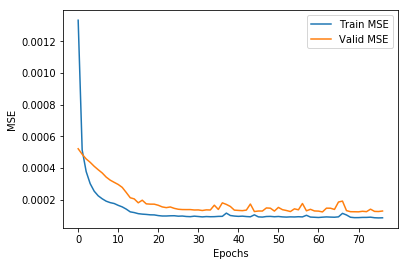

In [121]:
#Plotting Loss and accuracy
print(np.array(model.history['val_mean_squared_error']).min())

plt.plot(model.history['mean_squared_error'], label = "Train MSE")
plt.plot(model.history['val_mean_squared_error'], label = "Valid MSE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()

# Predicting on the Train set and plotting to compare

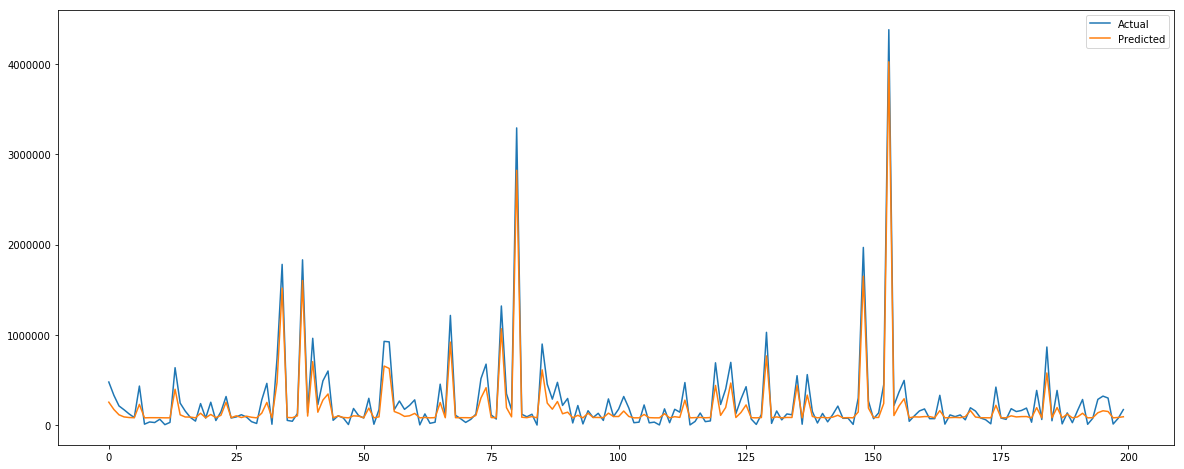

The RMSE of train set is


126003.43790948857

In [26]:
regressor.load_weights("best_weights.hdf5")

#Before inverse scaling the validation prediction
#print("Prediction before inverse scaling")
train_local_prediction = regressor.predict(train_local_X)
#print(local_prediction)

#After inverse scaling the validation prediction
#print("Prediction after inverse scaling")
train_local_inverse_scaled_prediction = dep_scaler.inverse_transform(train_local_prediction)
#print(local_inverse_scaled_prediction)

#local_inverse_scaled_prediction.min(), local_inverse_scaled_prediction.max()

#Reverse transform the actual local validation amount for plotting
train_local_Y_inverse_scaled = dep_scaler.inverse_transform(train_local_Y)

train_pred_DF = pd.DataFrame({'store_id': store_train_local, 
                              'total_sales': train_local_inverse_scaled_prediction[:,0]})
train_actual_DF = pd.DataFrame({'store_id': store_train_local, 
                                   'total_sales': train_local_Y_inverse_scaled[:,0]})

train_groupby_pred_DF = train_pred_DF.groupby(['store_id']).agg({"total_sales":"sum"}).reset_index()
train_groupby_actual_DF = train_actual_DF.groupby(['store_id']).agg({"total_sales":"sum"}).reset_index()


#print(validation_groupby_pred_DF.head())
#print(validation_groupby_actual_DF.head())

#Plotting the results
plt.figure(figsize = (20, 8))
plt.plot(train_groupby_actual_DF['store_id'], train_groupby_actual_DF['total_sales'],
        label = "Actual")
plt.plot(train_groupby_pred_DF['store_id'], train_groupby_pred_DF['total_sales'],
        label = "Predicted")
plt.legend()
plt.show()

print("The RMSE of train set is")
np.sqrt(sklearn.metrics.mean_squared_error(train_groupby_pred_DF.total_sales, train_groupby_actual_DF.total_sales) )

# Predicting on the validation set and plotting to compare
    # Unscaled

In [27]:
# regressor.load_weights("best_weights.hdf5")

# #Before inverse scaling the validation prediction
# #print("Prediction before inverse scaling")
# local_prediction = regressor.predict(test_local_X)
# print(local_prediction)

# test_local_Y_pred_DF_unscaled = pd.DataFrame({'store_id': store_test_local, 
#                                    'total_sales': local_prediction[:,0]})
# test_local_Y_actual_DF_unscaled = pd.DataFrame({'store_id': store_test_local, 
#                                    'total_sales': test_local_Y[:,0]})

# test_local_Y_groupby_pred_DF_unscaled = test_local_Y_pred_DF_unscaled.groupby(['store_id']).agg({"total_sales":"sum"}).reset_index()
# test_local_Y_groupby_actual_DF_unscaled = test_local_Y_actual_DF_unscaled.groupby(['store_id']).agg({"total_sales":"sum"}).reset_index()

# #Plotting the results
# plt.figure(figsize = (20, 8))
# plt.plot(test_local_Y_groupby_actual_DF_unscaled['store_id'], test_local_Y_groupby_actual_DF_unscaled['total_sales'],
#         label = "Actual")
# #plt.show()

# plt.plot(test_local_Y_groupby_pred_DF_unscaled['store_id'], test_local_Y_groupby_pred_DF_unscaled['total_sales'],
#         label = "Predicted")
# plt.legend()
# plt.show()

# print("The RMSE of validation set is")
# np.sqrt(sklearn.metrics.mean_squared_error(test_local_Y_groupby_pred_DF_unscaled.total_sales, test_local_Y_groupby_actual_DF_unscaled.total_sales) )


    
    # Scaled

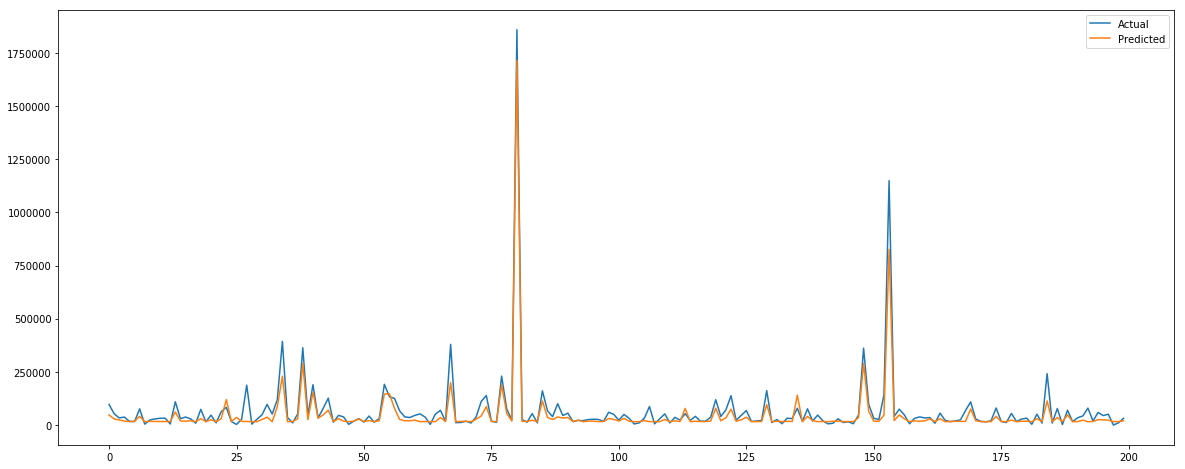

The RMSE of validation set is


42558.781258846058

In [28]:
regressor.load_weights("best_weights.hdf5")

#Before inverse scaling the validation prediction
#print("Prediction before inverse scaling")
local_prediction = regressor.predict(test_local_X)

#After inverse scaling the validation prediction
#print("Prediction after inverse scaling")
local_inverse_scaled_prediction = dep_scaler.inverse_transform(local_prediction)
#print(local_inverse_scaled_prediction)

#local_inverse_scaled_prediction.min(), local_inverse_scaled_prediction.max()

#Reverse transform the actual local validation amount for plotting
test_local_Y_inverse_scaled = dep_scaler.inverse_transform(test_local_Y)

test_local_Y_pred_DF = pd.DataFrame({'store_id': store_test_local, 
                                   'total_sales': local_inverse_scaled_prediction[:,0]})
test_local_Y_actual_DF = pd.DataFrame({'store_id': store_test_local, 
                                   'total_sales': test_local_Y_inverse_scaled[:,0]})

test_local_Y_groupby_pred_DF = test_local_Y_pred_DF.groupby(['store_id']).agg({"total_sales":"sum"}).reset_index()
test_local_Y_groupby_actual_DF = test_local_Y_actual_DF.groupby(['store_id']).agg({"total_sales":"sum"}).reset_index()

#print(validation_groupby_pred_DF.head())
#print(validation_groupby_actual_DF.head())

#Plotting the results
plt.figure(figsize = (20, 8))
plt.plot(test_local_Y_groupby_actual_DF['store_id'], test_local_Y_groupby_actual_DF['total_sales'],
        label = "Actual")
#plt.show()

plt.plot(test_local_Y_groupby_pred_DF['store_id'], test_local_Y_groupby_pred_DF['total_sales'],
        label = "Predicted")
plt.legend()
plt.show()


print("The RMSE of validation set is")
np.sqrt(sklearn.metrics.mean_squared_error(test_local_Y_groupby_pred_DF.total_sales, test_local_Y_groupby_actual_DF.total_sales) )


# Predicting on the Test prod

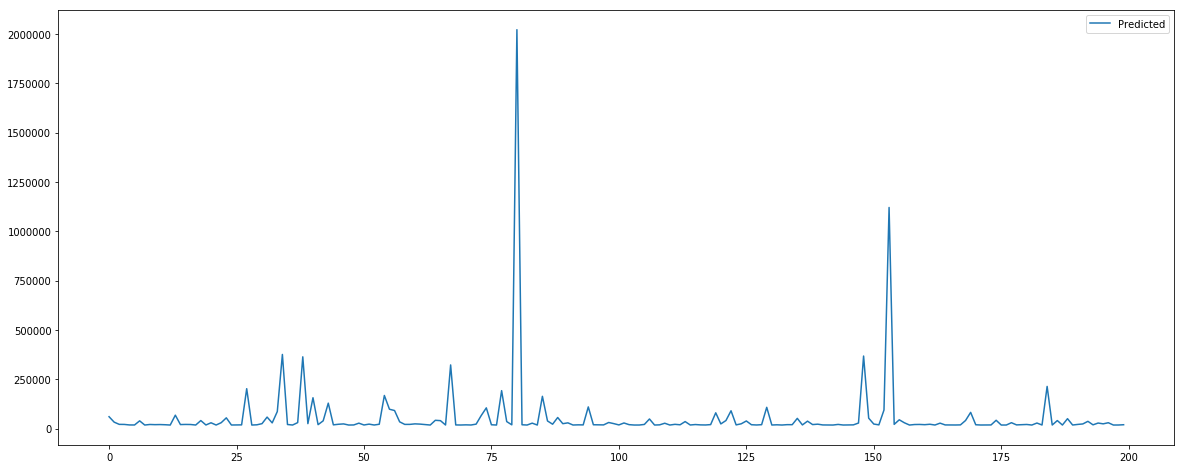

The RMSE of validation set is


In [29]:
regressor.load_weights("best_weights.hdf5")

#Before inverse scaling the validation prediction
#print("Prediction before inverse scaling")


prod_prediction = regressor.predict(test_prod_X)

#After inverse scaling the validation prediction
#print("Prediction after inverse scaling")
prod_inverse_scaled_prediction = dep_scaler.inverse_transform(prod_prediction)
#print(prod_prediction)
#print(prod_inverse_scaled_prediction)

#local_inverse_scaled_prediction.min(), local_inverse_scaled_prediction.max()

test_prod_Y_pred_DF = pd.DataFrame({'store_id': store_test_prod, 
                                   'total_sales': prod_inverse_scaled_prediction[:,0]})

test_prod_Y_groupby_pred_DF = test_prod_Y_pred_DF.groupby(['store_id']).agg({"total_sales":"sum"}).reset_index()

plt.figure(figsize = (20, 8))
plt.plot(test_prod_Y_groupby_pred_DF['store_id'], test_prod_Y_groupby_pred_DF['total_sales'],
        label = "Predicted")
plt.legend()
plt.show()


print("The RMSE of validation set is")
#np.sqrt(sklearn.metrics.mean_squared_error(test_local_Y_groupby_pred_DF.total_sales, test_local_Y_groupby_actual_DF.total_sales) )


In [30]:
print(test_prod_Y_groupby_pred_DF.head())
test_prod_Y_groupby_pred_DF.to_csv('sub_27.csv', index = False)

   store_id   total_sales
0         0  59809.933594
1         1  32326.906250
2         2  20996.865234
3         3  20675.775391
4         4  18081.351562


##########################################
# Trying the each day prediction for th validation set

# New method

In [27]:
# #each_test_local_prediction = pd.DataFrame()
# uniq_store = np.unique(test_local.store_id)
# #print(uniq_store)
# for store in uniq_store[0:1]:
#     temp = test_local.loc[test_local.store_id == store,].reset_index(drop = True)
    
#     preds_moving = []
#     actual_moving = []
#     #print(temp.head(30))
#     i = 0
    
#     print("Shape", temp.shape)
#     temp_v1 = temp.loc[i: (i + steps -1), ['amount']]
    
#     print("Shape", temp_v1.shape)
#     temp_v1_np = temp_v1.values
    
#     to_pred = np.array([temp_v1_np])
#     #print(temp.loc[i : (i + steps+10), ['amount']])
#     #print(to_pred)
    
#     days_to_forecast = 90
#     for i in range(days_to_forecast):
#         #print("to_predict")
#         actual_moving.append(temp.loc[(i + steps), 'amount'])
        
#         preds_one_step = regressor.predict(to_pred)
#         #print(preds_one_step)
#         preds_moving.append(preds_one_step[0,0])
#         preds_one_step = preds_one_step.reshape(1,1,1)
        
#         #print(to_pred.shape, preds_one_step.shape)
#         to_pred = np.concatenate((to_pred[:,1:,:], 
#                                   preds_one_step), axis=1)

# #print(actual_moving)
# #print(preds_moving)

In [28]:
# #print(preds_moving)

# plt.plot(actual_moving, label = 'Actual')

# plt.plot(preds_moving, label = 'Pred')
# plt.legend()
# plt.show()



# My method

In [29]:
# each_test_local_prediction = pd.DataFrame()
# uniq_store = np.unique(test_local.store_id)
# #print(uniq_store)
# for store in uniq_store[180:181]:
#     temp = test_local.loc[test_local.store_id == store,].reset_index(drop = True)
#     print(store)
#     #print(temp.shape)
#     #for i in range(temp.shape[0] - steps):
#     #    to_get_x = print(temp.iloc[i:i+steps,])
#     #temp.[0:1]
    
#     for i in range(temp.shape[0] - steps):
#     #for i in range(0,6):
#         #print(i, steps)
#         #print(temp.iloc[i: (i + 1 + steps),])
#         #temp_v1 = temp.loc[i: (i + steps -1), ['amount', 'days_of_week', 'holyday']]
#         temp_v1 = temp.loc[i: (i + steps -1), ['amount']]
#         #print(temp_v1)
#         print("Shape", temp_v1.shape)
#         temp_v1_np = temp_v1.values
#         #print(temp_v1_np)
#         to_pred = np.array([temp_v1_np])
#         #print(to_pred)        
#         #print(to_pred.shape)        
#         prod_prediction = regressor.predict(to_pred)
#         #print("\n prediction is", prod_prediction)
#         temp.amount[(i + steps)] = prod_prediction
#     each_test_local_prediction = each_test_local_prediction.append(temp)
#         #print(temp.iloc[i : (i + 1 + steps),])
#         #print("")
# print(each_test_local_prediction.shape)

In [30]:
# plt.figure(figsize = (20, 8))
    
# for i in np.unique(each_test_local_prediction.store_id):
#     a = each_test_local_prediction.loc[each_test_local_prediction.store_id == i,].reset_index(drop = True)
#     plt.plot(a.index, dep_scaler.inverse_transform(a.loc[:,['amount']]),
#             label = i)
# plt.legend()    
# plt.show()

# plt.figure(figsize = (20, 8))
    
# for i in np.unique(each_test_local_prediction.store_id):
#     a = each_test_local_prediction.loc[each_test_local_prediction.store_id == i,].reset_index(drop = True)
#     plt.plot(a.index, a.loc[:,['amount']],
#             label = i)
# plt.legend()    
# plt.show()

##########################################

# Predicting on the production test set

In [31]:
# #Making all the amount after March 31st 2018 as 0 which is to be predicted
# summarized_test_prod.loc[summarized_test_prod['date'] > datetime(2018,3,31),['amount']] = None
# #print(summarized_test_prod.head())
# #print(summarized_test_prod.tail())

# print("For sanity check all the amount values after 31st March should be 0")
# print(summarized_test_prod.loc[summarized_test_prod['date'] <= datetime(2018,3,31),['amount']].describe())
# print(summarized_test_prod.loc[summarized_test_prod['date'] > datetime(2018,3,31),['amount']].describe())

# summarized_test_prod_final = summarized_test_prod.copy()
# summarized_test_prod_final = summarized_test_prod_final.sort_values(['store_id', 'date']).reset_index(drop = True)

In [32]:
# final_prod_prediction = pd.DataFrame()
# uniq_store = np.unique(summarized_test_prod_final.store_id)
# #print(uniq_store)
# for store in uniq_store[180:200]:
#     temp = summarized_test_prod_final.loc[summarized_test_prod_final.store_id == store,].reset_index(drop = True)
#     print(store)
#     #print(temp.shape)
#     #for i in range(temp.shape[0] - steps):
#     #    to_get_x = print(temp.iloc[i:i+steps,])
#     #temp.[0:1]
    
#     for i in range(temp.shape[0] - steps):
#     #for i in range(0,6):
#         #print(i, steps)
#         #print(temp.iloc[i: (i + 1 + steps),])
#         #temp_v1 = temp.loc[i: (i + steps -1), ['amount', 'days_of_week', 'holyday']]
#         temp_v1 = temp.loc[i: (i + steps -1), ['amount']]
#         #print(temp_v1)
#         #print("Shape", temp_v1.shape)
#         temp_v1_np = temp_v1.values
#         #print(temp_v1_np)
#         to_pred = np.array([temp_v1_np])
#         #print(to_pred)        
#         #print(to_pred.shape)        
#         prod_prediction = regressor.predict(to_pred)
#         #print("\n prediction is", prod_prediction)
#         temp.amount[(i + steps)] = prod_prediction
#     final_prod_prediction = final_prod_prediction.append(temp)
#     print(final_prod_prediction.shape)
#         #print(temp.iloc[i : (i + 1 + steps),])
#         #print("")

In [33]:
# plt.figure(figsize = (20, 8))
    
# for i in np.unique(final_prod_prediction.store_id):
#     a = final_prod_prediction.loc[final_prod_prediction.store_id == i,].reset_index(drop = True)
#     plt.plot(a.index, dep_scaler.inverse_transform(a.loc[:,['amount']]),
#             label = i)
# plt.legend()    
# plt.show()

# plt.figure(figsize = (20, 8))
    
# for i in np.unique(final_prod_prediction.store_id):
#     a = final_prod_prediction.loc[final_prod_prediction.store_id == i,].reset_index(drop = True)
#     plt.plot(a.index, a.loc[:,['amount']],
#             label = i)
# plt.legend()    
# plt.show()

In [34]:
# # Rough work
# print(np.unique(final_prod_prediction.store_id))
# print(final_prod_prediction.head())
# test_prod_prediction = final_prod_prediction.loc[final_prod_prediction['date']> datetime(2018,3,31), ]
# print(test_prod_prediction.head())
# print(test_prod_prediction.tail())
# inverse_test_prod_prediction = dep_scaler.inverse_transform(test_prod_prediction.loc[:,['amount']])

# sub_DF = pd.DataFrame({'store_id': test_prod_prediction['store_id'], 
#                        'total_sales': inverse_test_prod_prediction[:,0]})

# sub_grouped_DF = sub_DF.groupby(['store_id']).agg({'total_sales':'sum'}).reset_index()

# plt.figure(figsize = (20, 8))
# plt.bar(sub_grouped_DF['store_id'], sub_grouped_DF['total_sales'], label = 'Predicted')
# #plt.plot(sub_DF['store_id'], np.absolute(sub_DF['total_sales']), label = 'abs Predicted')
# plt.legend()
# plt.show()

In [35]:
# print(final_prod_prediction.head())
# final_prod_prediction.loc[final_prod_prediction['date']> datetime(2018,3,31), ].head()


In [36]:
# #prod_prediction = regressor.predict(test_prod_X)
# prod_prediction     = final_prod_prediction.loc[final_prod_prediction['date']> datetime(2018,3,31), ['amount']]
# test_prod_store_ids = final_prod_prediction.loc[final_prod_prediction['date']> datetime(2018,3,31), ['store_id']]
# print("Prediction before inverse scaling")
# #print(prod_prediction.head())
# #print(prod_prediction.tail())

# prod_inverse_scaled_prediction = dep_scaler.inverse_transform(prod_prediction)
# print(prod_inverse_scaled_prediction.shape, test_prod_store_ids.shape)
# #print("Prediction after inverse scaling")
# #print(len(prod_inverse_scaled_prediction))
# #print(final_prod_prediction.iloc[243:303,])
# #print(prod_inverse_scaled_prediction[-60: len(prod_inverse_scaled_prediction)])


In [37]:
# prod_inverse_scaled_prediction[0:6]

In [38]:

# sub_DF = pd.DataFrame({'store_id': test_prod_store_ids, 
#                        'total_sales': prod_inverse_scaled_prediction[:,0]})

# sub_grouped_DF = sub_DF.groupby(['store_id']).agg({'total_sales':'sum'}).reset_index()

# plt.figure(figsize = (20, 8))
# plt.bar(sub_grouped_DF['store_id'], sub_grouped_DF['total_sales'], label = 'Predicted')
# #plt.plot(sub_DF['store_id'], np.absolute(sub_DF['total_sales']), label = 'abs Predicted')
# plt.legend()
# plt.show()



In [39]:
# print(sub_DF['total_sales'].describe())
# print(np.absolute(sub_DF['total_sales']).describe())

In [40]:
# print(sub_DF.head())
# sub_DF = sub_DF.groupby(['store_id']).agg({'total_sales':'sum'}).reset_index()
# print(sub_DF.head())
# sub_DF.to_csv('sub_22.csv', index = False)